# Dependencias

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import os
from PIL import Image
from pathlib import Path

In [3]:
dir = Path.cwd().parent / 'data' / 'UTKFace'
names = os.listdir(dir)

In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
np.random.shuffle(names)

In [6]:
# Check shuffle
names[0]

'49_1_0_20170104185652921.jpg.chip.jpg'

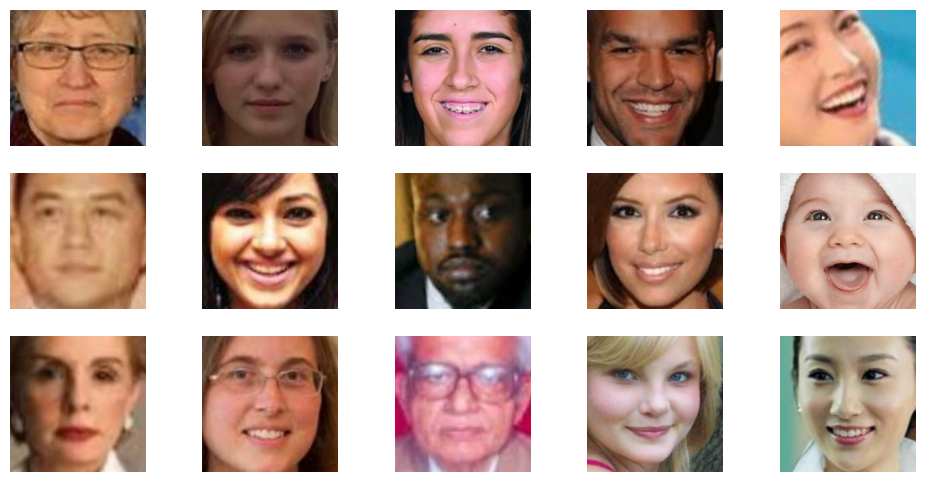

In [7]:
fig, ax = plt.subplots(3, 5, figsize=(12, 6), sharex=True, sharey=True)
for i in range(15):
    ax[i//5, i%5].imshow(Image.open(dir / names[i]))
    ax[i//5, i%5].axis('off')
plt.show()

In [8]:
bytesList = tf.train.BytesList
floatList = tf.train.FloatList
int64List = tf.train.Int64List
feat = tf.train.Feature
feats = tf.train.Features
example = tf.train.Example

In [9]:
def create_ex(folder_path, file_path):
    full_path = folder_path / file_path
    image = tf.io.serialize_tensor(np.array(Image.open(full_path)))
    split = file_path.split('_')
    age = int(split[0])
    gender = int(split[1])
    
    ex = example(
        features=feats(
            feature = {
                'image': feat(bytes_list=bytesList(value=[image.numpy()])),
                'age': feat(int64_list=int64List(value=[age])),
            }
        ))
    
    return ex
    

In [10]:
def create_tf_record(set, file_name):
    with tf.io.TFRecordWriter("%s.tfrecord" %file_name) as writer:
        for file in set:
            if file != 'utkcropped':
                ex = create_ex(dir, file)
                writer.write(ex.SerializeToString())

In [11]:
train_range = [i for i in range(1, 16597)]
valid_range = [i for i in range(16597, 18968)]
test_range = [i for i in range(18968, len(names)+1)]

In [15]:
create_tf_record(names[:16597], 'train_data')

In [16]:
create_tf_record(names[16597:18968], 'valid_data')

In [17]:
create_tf_record(names[18968:], 'test_data')

In [12]:
@tf.function
def preprocess(tfrecord):
    feat_descript = {
        'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'age': tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(tfrecord, feat_descript)
    image = tf.io.parse_tensor(example['image'], out_type=tf.uint8)
    image = tf.reshape(image, shape = [200, 200, 3])
    image = tf.image.resize(image, [224, 224])
    image = keras.applications.xception.preprocess_input(image)
    return image, example['age']

def utkface_dataset(filepaths, n_read_threads=5, shuffle_buffer_size = None, 
                    n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [13]:
train_set = utkface_dataset('./train_data.tfrecord')
valid_set = utkface_dataset('./valid_data.tfrecord')
test_set = utkface_dataset('./test_data.tfrecord')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


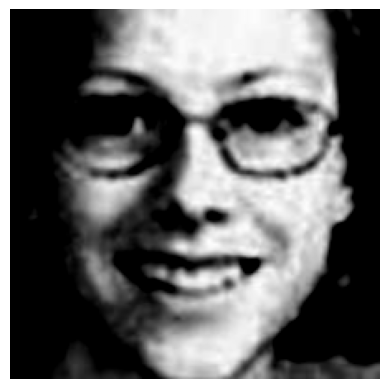

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 23 years old


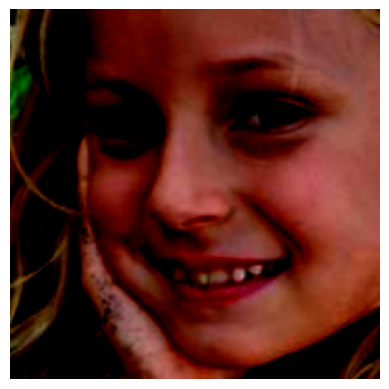

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


I am 8 years old


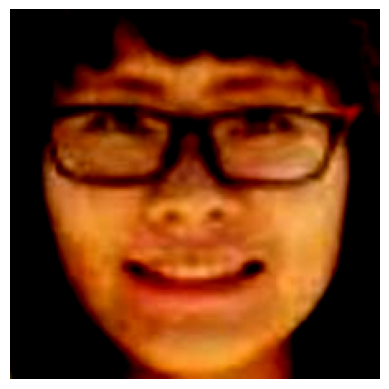

I am 23 years old


In [14]:
for img, age in test_set.take(3):
    plt.imshow(img[0])
    plt.axis('off')
    plt.show()
    print("I am", age[0].numpy(), "years old")
    

In [15]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(1, activation='relu')(avg)
model = keras.models.Model(input=base_model.input, outputs=output)

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of b0042744bf5b25fce3cb969f33bebb97 so we will re-download the data.


Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5: 403 -- Forbidden

In [ ]:
for layer in base_model.layers:
    layer.trainable = False
    
optimizer = keras.optimizers.Nadam(learning_rate=1e-4)
model.compile(loss='mean_squared_error', optimizer=optimizer)

history = model.fit(train_set, validation_data = valid_set, epochs = 15)

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

checkpoint_cb = keras.callbacks.ModelCheckpoint('my_model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_set, validation_data = valid_set, epochs = 300, callbacks=[checkpoint_cb, early_stopping_cb])

In [ ]:
model = keras.models.load_model('my_model.h5')

In [ ]:
rmsq = tf.sqrt(model.evaluate(test_set))
print("El error cuadrático medio para el modelo es: %.3f" %rmsq.numpy())